In [9]:
import itertools
import os
import zipfile
import csv
import textwrap
import time
import multiprocessing

from difflib import SequenceMatcher
from pprint import pprint
from collections import Counter, deque

import spacy
import numpy
import pandas
import umap

import phasor

from headless import load_pages
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
from pyhash import city_64

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, TapTool, OpenURL, ColumnDataSource
from bokeh.palettes import magma

output_notebook()

Loading BokehJS ...

In [3]:
dataset = 'test-batch'
dataset = 'rand-fiction-1k'
dataset = 'pd-ic-combined'

secure_paths = (f'/media/secure_volume/volumes/zip/{dataset}',
                f'/media/secure_volume/derived/{dataset}/fft',
                f'/media/secure_volume/derived/{dataset}/srp_fft',
                f'/media/secure_volume/worksets/{dataset}-hathifiles.csv')

test_paths = ('../ht-open-test-data/fiction_998/',
              '../ht-open-test-data/fiction_fft',
              '../ht-open-test-data/fiction_srp_fft',
              '../ht-open-test-data/fiction.csv')

spe_paths = (f'../spevecs/volumes/{dataset}',
             f'../spevecs/derived/{dataset}/fft',
             f'../spevecs/derived/{dataset}/srp_fft',
             f'../spevecs/worksets/{dataset}-hathifiles.csv')

(path_to_volumes, 
 path_to_fft, 
 path_to_srp_fft, 
 path_to_meta) = spe_paths

In [4]:
# for test_path in phasor.volume_paths(path_to_volumes)[:3]:
#     print('testing with {}'.format(test_path))
#     try:
#         phasor.test_fft_reshape(test_path, srp=False)
#     except Exception as e:
#         print('skipping {} -- {}: {}'.format(test_path, type(e), e))

# for test_path in phasor.volume_paths(path_to_volumes):
#     phasor.test_htid_conversion(test_path)

In [5]:
paths = phasor.save_embedding_ffts(path_to_volumes, path_to_fft, srp=False)
paths = phasor.save_embedding_ffts(path_to_volumes, path_to_srp_fft, srp=True)

In [6]:
# n_docs = None  # Load all the docs!
n_docs = 10000
data, metadata = phasor.load_fft_metadata(path_to_fft, path_to_meta, 
                                          end=20, csv_delim=',', n_docs=n_docs)
data[numpy.isnan(data)] = 0

/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,4,10,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


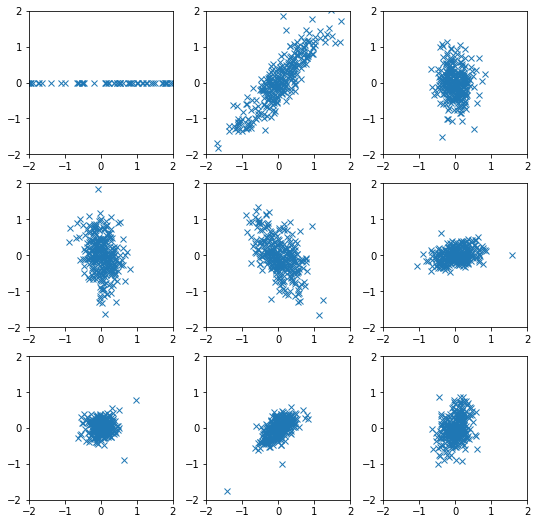

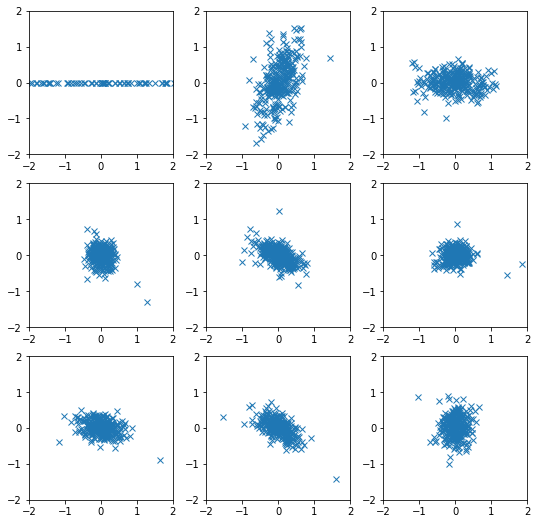

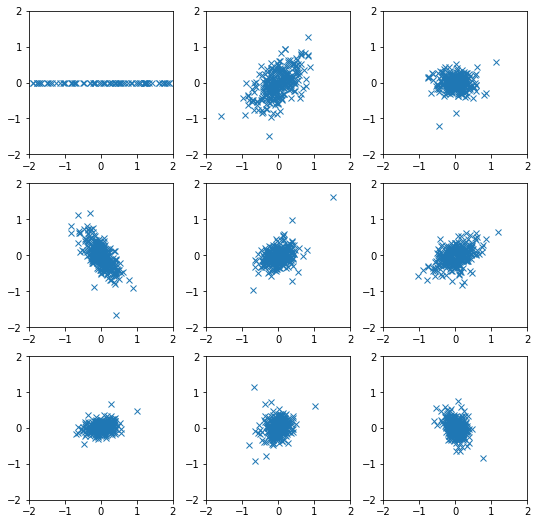

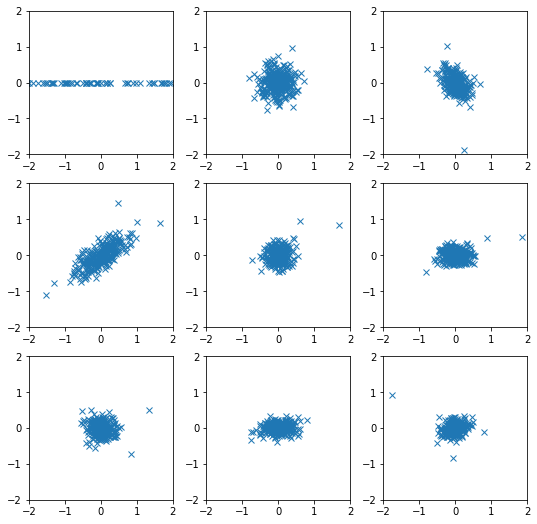

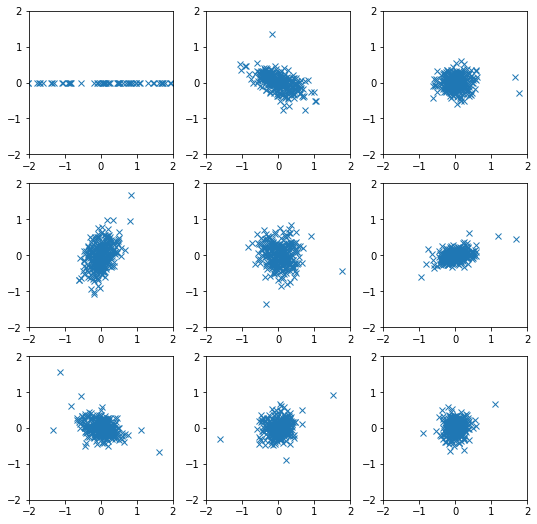

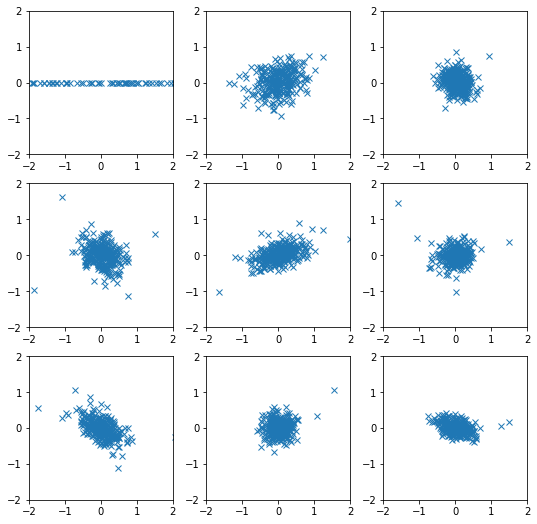

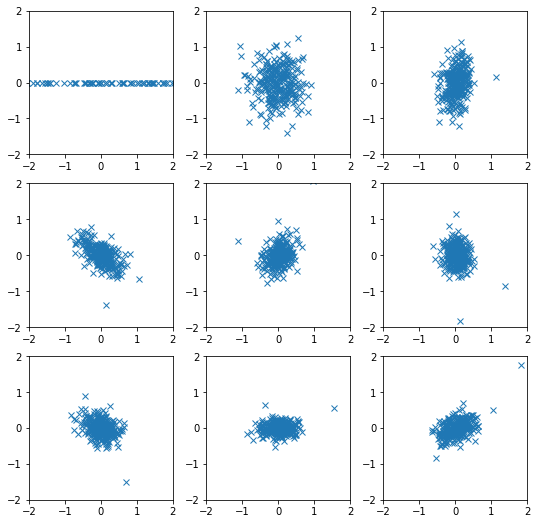

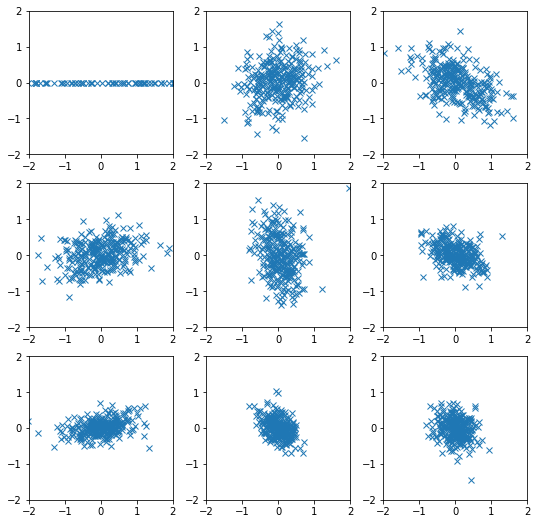

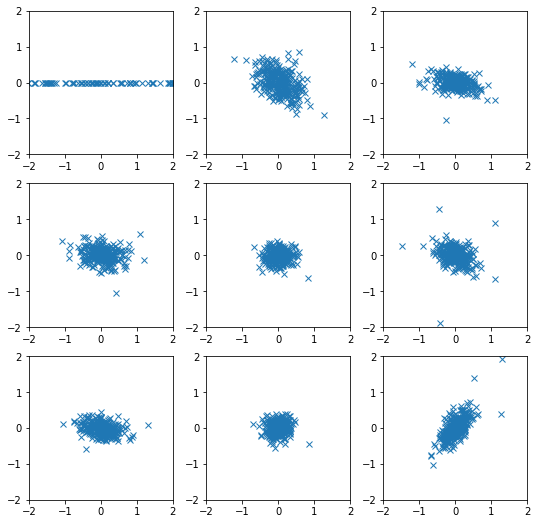

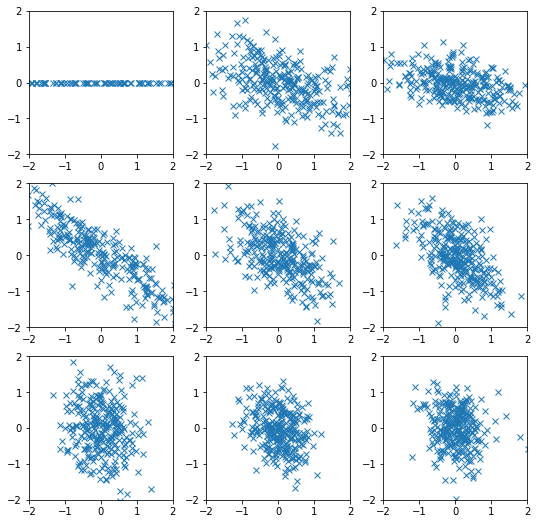

In [7]:
def plot_sample_phasor_blobs(data, index=0):
    data = data[index:index + 1]
    bands = [phasor.slice_vec_bands(data, start=n, end=n + 1)
             for n in range(9)]
    bands = [phasor.unflatten_vec(ba) for ba in bands]
    
    fig, ax_grid = plt.subplots(3, 3, figsize=(9, 9))
    for ax, ba in zip(ax_grid.flat, bands):
        ax.plot(ba.real, ba.imag, 'x')
        ax.set(xlim=(-2, 2), ylim=(-2, 2))
        
        # I don't understand the difference between
        # `ax.set_aspect('equal')` and `ax.axis('equal')`.
        # But I like the look of `set_aspect` better.
        ax.set_aspect('equal')

    plt.show()

for i in range(10):
    plot_sample_phasor_blobs(data, i)

In [42]:
import importlib
phasor = importlib.reload(phasor)

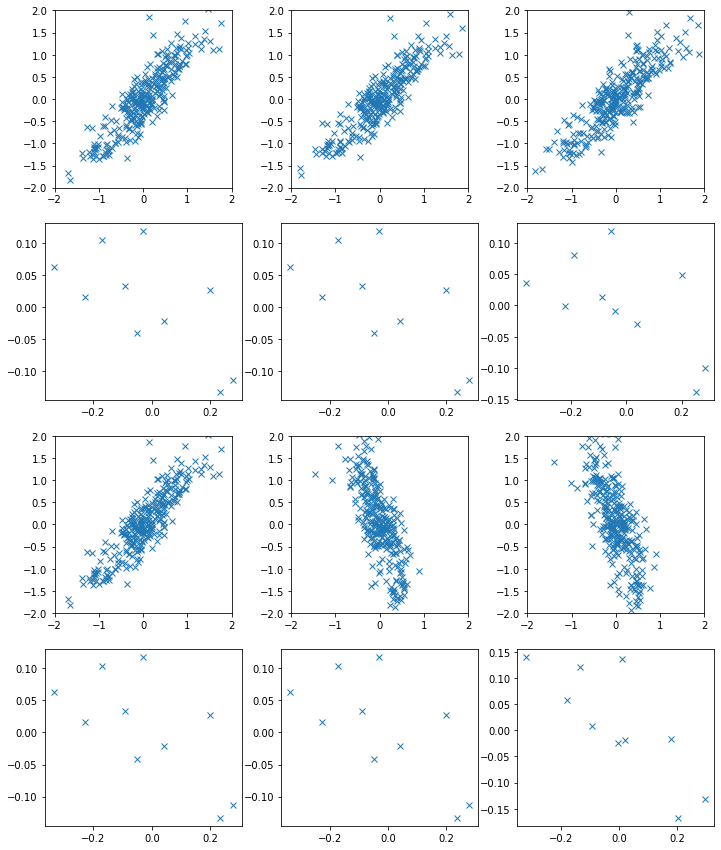

In [36]:
def complex_blob(n, scale=1.0):
    x, y = numpy.random.multivariate_normal([0, 0], [[scale ** 2, 0], [0, scale ** 2]], n).T
    return x + y * 1j

def perturb_blob(start, n=100):
    """
    Create a bunch of perturbed copies of a gaussian blob by
    randomly rotating it and adding a little bit of noise.
    """
    offset = numpy.array([start * (c / (c * c.conjugate()) ** 0.5) 
                          for c in complex_blob(n)])
    noisy = offset + numpy.array([complex_blob(len(start), scale=0.1) 
                                  for o in offset])
    return start, offset, noisy

def perturb_phasor_blob(data, index=0, band=1, n=100):
    data = data[index:index + 1]
    start = phasor.slice_vec_bands(data, start=band, end=band + 1)
    start = phasor.unflatten_vec(start)[:, 0]
    return perturb_blob(start, n)

def plot_blob(c, equal=True, ax=None):
    if ax is None:
        plt.plot(c.real, c.imag, 'x')
        ax = plt.gca()
    else:
        ax.plot(c.real, c.imag, 'x')
        
    if equal:
        ax.set_aspect('equal')
        ax.set(xlim=(-2, 2), ylim=(-2, 2))
        
    if ax is None:
        plt.show()

def plot_perturbed_phasor_blobs(data, index=0, band=1):
    start, offset, noisy = perturb_phasor_blob(data, index, band, n=2)
    psig = phasor.PhasorSignature(n_components=20, n_anchors=3)
    psig.fit(data[:100])

    fig, ax_grid = plt.subplots(4, 3, figsize=(12, 15))
    axes = ax_grid.flat

    plot_blob(start, ax=axes[0])
    plot_blob(offset[0], ax=axes[1])
    plot_blob(noisy[0], ax=axes[2])
    
    sigs_0 = psig.signature(start)
    sigs_0 = sigs_0[::2] + sigs_0[1::2] * 1j
    plot_blob(sigs_0, equal=False, ax=axes[3])
    
    sigo_0 = psig.signature(offset[0])
    sigo_0 = sigo_0[::2] + sigo_0[1::2] * 1j
    plot_blob(sigo_0, equal=False, ax=axes[4])
    
    sign_0 = psig.signature(noisy[0])
    sign_0 = sign_0[::2] + sign_0[1::2] * 1j
    plot_blob(sign_0, equal=False, ax=axes[5])
    
    plot_blob(start, ax=axes[6])
    plot_blob(offset[1], ax=axes[7])
    plot_blob(noisy[1], ax=axes[8])
    
    sigs_1 = psig.signature(start, )
    sigs_1 = sigs_1[::2] + sigs_1[1::2] * 1j
    plot_blob(sigs_1, equal=False, ax=axes[9])
    
    sigo_1 = psig.signature(offset[1])
    sigo_1 = sigo_1[::2] + sigo_1[1::2] * 1j
    plot_blob(sigo_1, equal=False, ax=axes[10])
    
    sign_1 = psig.signature(noisy[1])
    sign_1 = sign_1[::2] + sign_1[1::2] * 1j
    plot_blob(sign_1, equal=False, ax=axes[11])
    
    plt.show()


plot_perturbed_phasor_blobs(data)

In [41]:
psig = phasor.PhasorSignature()

blob_copies = []
for i in range(100):
    start, offset, noisy = perturb_phasor_blob(data, index=i, n=2)
    blob_copies.extend(noisy)
    
signatures = [psig.signature(n) for n in blob_copies]
signatures = psig.scaler.fit_transform(signatures)

same_diffs = [a - b for a, b in zip(signatures[0::2], signatures[1::2])]
diff_diffs = [a - b for a, b in zip(signatures[1::2], signatures[2::2])]
same_mags = [mag for d in same_diffs for mag in (d * d.conjugate()) ** 0.5]
diff_mags = [mag for d in diff_diffs for mag in (d * d.conjugate()) ** 0.5]

print(max(same_mags))
print(numpy.mean(same_mags))
print(max(diff_mags))
print(numpy.mean(diff_mags))

4.281066128307315
0.39280053229856426
6.537213293635563
1.0731756697859092


In [ ]:
# phasor.show_umap_bokeh(
#     phasor.slice_vec_bands(data, start=0, end=2),
#     metadata,
#     n_neighbors=50
#     # color_field='pub_date'
# )

In [43]:
kwargs = dict(
    n_neighbors=10, 
    n_components=5, 
    metric='euclidean',
    # random=True
    signature=True
)

# dedupe_slice_full = phasor.Deduplicator(phasor.slice_vec_bands(data, start=0, end=10), **kwargs)
dedupe_slices = [phasor.Deduplicator(phasor.slice_vec_bands(data, start=i, end=i + 1), **kwargs)
                 for i in range(10)]
dedupe_boolean = phasor.Deduplicator(dedupe_slices[0])
for ds in dedupe_slices[1:5]:
    dedupe_boolean.merge(ds)

/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarning: invalid value encountered in true_divide
  
/Users/enderlej/Dropbox/work/hathi/semantic-phasor-demo/phasor.py:549: RuntimeWarni

In [44]:
radius = 1.0

pairs_boolean = dedupe_boolean(radius)
pairs_single = dedupe_slices[0](radius)
# pairs_full = dedupe_slice_full(radius)
print("Number of candidates found by each test")
print()
print("Boolean test:     ", len(pairs_boolean))
print("Single-band test: ", len(pairs_single))
# print("Full-band test:   ", len(pairs_full))

Number of candidates found by each test

Boolean test:      510
Single-band test:  5890802


In [45]:
likely_true_positives_boolean = set(
    frozenset((a, b)) for a, b in pairs_boolean
    if metadata['title'][a] == metadata['title'][b]
)
likely_true_positives_single = set(
    frozenset((a, b)) for a, b in pairs_single
    if metadata['title'][a] == metadata['title'][b]
)
# likely_true_positives_full = set(
#     frozenset((a, b)) for a, b in pairs_full
#     if metadata['title'][a] == metadata['title'][b]
# )

print("Number of likely duplicates (based on title) found by each test")
print()
print("Boolean test:     ", len(likely_true_positives_boolean))
print("Single-band test: ", len(likely_true_positives_single))
# print("Full-band test:   ", len(likely_true_positives_full))
print()
print("Number of identically-titled volumes missed by single test, caught by boolean test:")
print(len(likely_true_positives_boolean - likely_true_positives_single))
print()
print("Number of identically-titled volumes missed by boolean test, caught by single test:")
print(len(likely_true_positives_single - likely_true_positives_boolean))
print()
print("NOTE: Many false positives will still appear in these counts because "
      "different volumes from multi-volume works may have the same title even "
      "though they do not contain the same content. This accounts for many of the "
      "matches captured by the single-band but not by the boolean test. The "
      "single-band test captures the broad semantic similarity between volumes of "
      "the same work, but can't make fine-grained distinctions between individual "
      "volumes of the work. A single ten-volume work can produce as many as one "
      "hundred false positives here, so this can give the impression that the "
      "boolean test has missed many duplicates. Hand check a few and you'll "
      "probably see that it hasn't.")

Number of likely duplicates (based on title) found by each test

Boolean test:      82
Single-band test:  8028

Number of identically-titled volumes missed by single test, caught by boolean test:
0

Number of identically-titled volumes missed by boolean test, caught by single test:
7946

NOTE: Many false positives will still appear in these counts because different volumes from multi-volume works may have the same title even though they do not contain the same content. This accounts for many of the matches captured by the single-band but not by the boolean test. The single-band test captures the broad semantic similarity between volumes of the same work, but can't make fine-grained distinctions between individual volumes of the work. A single ten-volume work can produce as many as one hundred false positives here, so this can give the impression that the boolean test has missed many duplicates. Hand check a few and you'll probably see that it hasn't.


In [46]:
pairs = list(pairs_boolean)

def get_root(links, ix):
    while links[ix] != ix:
        ix = links[ix]
    return ix

def set_root(links, ix, root):
    while links[ix] != ix:
        old_ix = ix
        ix = links[ix]
        links[old_ix] = root
    links[ix] = root

def cluster_pairs(pairs, maxn=None):
    if maxn is None:
        maxn = max(x for p in pairs for x in p) + 1
        
    dupe_link = list(range(maxn))
    for a, b in pairs:
        a_root = get_root(dupe_link, a)
        set_root(dupe_link, a, a_root)
        set_root(dupe_link, b, a_root)
    
    for i in range(len(dupe_link)):
        dupe_link[i] = get_root(dupe_link, i)

    dupe_clusters = {c: [] for c in dupe_link}
    for i, c in enumerate(dupe_link):
        dupe_clusters[c].append(i)

    return list(dupe_clusters.values())

dupe_clusters = cluster_pairs(pairs, len(data))
print('Total number of items:', sum(len(c) for c in dupe_clusters))
print('Number of clusters:', len(dupe_clusters))
print('Largest cluster:', max(len(c) for c in dupe_clusters))
print('Number of one-item clusters:', sum(len(c) == 1 for c in dupe_clusters))

Total number of items: 10000
Number of clusters: 9634
Largest cluster: 48
Number of one-item clusters: 9410


In [47]:
def sort_cluster(indices, data):
    centroid = sum(data[i] for i in indices) / len(indices)
    distances = [((data[i] - centroid) ** 2).sum() ** 0.5 for i in indices]
    order = sorted(range(len(distances)), key=distances.__getitem__)
    indices_sorted = [indices[o] for o in order]
    distances = [distances[o] for o in order]
    return list(zip(indices_sorted, distances))

def mean_dist(cluster_dist):
    return sum(d for c, d in cluster_dist) / len(cluster_dist)

# sort_data = phasor.PhasorSignature().fit_transform(data)
sort_data = data

display_clusters = [sort_cluster(dc, sort_data)
                    for dc in dupe_clusters if len(dc) > 1]
display_clusters.sort(key=mean_dist)

for i, dc in enumerate(display_clusters):
    print()
    print(f'Cluster {i}, {len(dc)} items:')
    for j, (vol, dist) in enumerate(dc):
        vol_id = metadata.index[vol]
        vol_ti = metadata['title'][vol]
        vol_au = metadata['author'][vol]
        print('    Item', j, ' ~~  distance from cluster centroid:', dist)
        print('   ', vol_au, ' ~~ ', vol_ti)
        print('   ', phasor.htid_url(vol_id))
        print()



Cluster 0, 2 items:
    Item 0  ~~  distance from cluster centroid: 0.5020084573253685
    Stevenson, Robert Louis, 1850-1894.  ~~  The novels and tales of Robert Louis Stevenson.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000121140465

    Item 1  ~~  distance from cluster centroid: 0.5020084573253685
    Stevenson, Robert Louis, 1850-1894.  ~~  The novels and tales of Robert Louis Stevenson /
    https://babel.hathitrust.org/cgi/pt?id=inu.30000121140564


Cluster 1, 2 items:
    Item 0  ~~  distance from cluster centroid: 0.5449480166710566
    Goncharov, Ivan Aleksandrovich, 1812-1891.  ~~  Oblomov / Ivan Goncharov ; translated from the Russian by Natalie Duddington.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000036890238

    Item 1  ~~  distance from cluster centroid: 0.5449480166710566
    Goncharov, Ivan Aleksandrovich, 1812-1891.  ~~  Oblomov / Ivan Goncharov; translated from the Russian by Natalie Duddington.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000037

Cluster 60, 2 items:
    Item 0  ~~  distance from cluster centroid: 2.864314914034037
    Ainsworth, William Harrison, 1805-1882.  ~~  The Tower of London, a historical romance; by William Harrison Ainsworth, with forty plates and fifty-eight woodcuts by George Cruikshank.
    https://babel.hathitrust.org/cgi/pt?id=coo.31924013205434

    Item 1  ~~  distance from cluster centroid: 2.864314914034037
    Ainsworth, William Harrison, 1805-1882.  ~~  The tower of London : a historical romance / by William Harrison Ainsworth ; with forty plates and fifty-eight woodcuts by George Cruikshank.
    https://babel.hathitrust.org/cgi/pt?id=ien.35556015580244


Cluster 61, 2 items:
    Item 0  ~~  distance from cluster centroid: 2.8972761187158285
    Danaher, Kevin.  ~~  In Ireland long ago.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000118588460

    Item 1  ~~  distance from cluster centroid: 2.8972761187158285
    Danaher, Kevin.  ~~  In Ireland long ago.
    https://babel.hathitrust.or

    Item 0  ~~  distance from cluster centroid: 7.444415043382171
    Conrad, Joseph, 1857-1924.  ~~  Almayer's folly : a story of an Eastern river. / Joseph Conrad. Drawings by Clarke Hutton.--
    https://babel.hathitrust.org/cgi/pt?id=inu.30000007151073

    Item 1  ~~  distance from cluster centroid: 7.444415043382171
    Conrad, Joseph, 1857-1924  ~~  Almayer's folly.
    https://babel.hathitrust.org/cgi/pt?id=inu.32000002820936


Cluster 122, 5 items:
    Item 0  ~~  distance from cluster centroid: 4.94626274440802
    Bunyan, John, 1628-1688.  ~~  The pilgrim's progress from this world to that which is to come, delivered under the similitude of a dream, by John Bunyan.
    https://babel.hathitrust.org/cgi/pt?id=inu.32000001187881

    Item 1  ~~  distance from cluster centroid: 5.350273567406974
    Bunyan, John, 1628-1688.  ~~  The pilgrim's progress from this world to that which is to come, delivered under the similitude of a dream, by John Bunyan.
    https://babel.hathitrust

    Item 2  ~~  distance from cluster centroid: 18.936827997049658
    Devlin, Denyse, 1958-  ~~  If not now / Denyse Devlin.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000110565011


Cluster 169, 3 items:
    Item 0  ~~  distance from cluster centroid: 13.652943924576018
    Dickens, Charles, 1812-1870.  ~~  The posthumous papers of the Pickwick Club / by Charles Dickens.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000117261002

    Item 1  ~~  distance from cluster centroid: 18.555528763823414
    Dickens, Charles, 1812-1870.  ~~  The posthumous papers of the Pickwick Club / by Charles Dickens ; introd. by Bernard Darwin ; ill. by Seymour and Phiz.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000055087435

    Item 2  ~~  distance from cluster centroid: 19.84929563872521
    Dickens, Charles, 1812-1870.  ~~  The posthumous papers of the Pickwick Club.
    https://babel.hathitrust.org/cgi/pt?id=coo.31924014156909


Cluster 170, 2 items:
    Item 0  ~~  distance from clu

    https://babel.hathitrust.org/cgi/pt?id=inu.30000117261259

    Item 6  ~~  distance from cluster centroid: 35.339252863759725
    O'Dell, Tawni.  ~~  Sister mine : a novel / Tawni O'Dell.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000111084525

    Item 7  ~~  distance from cluster centroid: 35.850225207952846
    Tolstoy, Leo, graf, 1828-1910.  ~~  Anna Karenina / by Leo Tolstoy ; translated by Constance Garnett ; the text edited and revised by Gustavus Spett ; and the translation revised by Bernard Guilbert Guerney ; introduced by Lionel Trilling.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000117261812

    Item 8  ~~  distance from cluster centroid: 35.90351144093099
    Meadows, Rae.  ~~  Calling out : a novel / by Rae Meadows.
    https://babel.hathitrust.org/cgi/pt?id=inu.30000109290381

    Item 9  ~~  distance from cluster centroid: 36.0209018639699
    Waugh, Auberon.  ~~  Path of dalliance / Auberon Waugh.
    https://babel.hathitrust.org/cgi/pt?id=inu.3200000

In [48]:
data_freq_array = [phasor.unflatten_vec(r) / len(data) for r in data]  # 300 rows, 20 cols in each array, ~1000 arrays

data_freq_mean = data_freq_array[0]
for dfa in data_freq_array[1:]:
    data_freq_mean += dfa

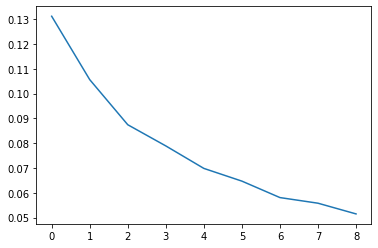

In [49]:
power_a = data_freq_mean[:, 1:].real
power_b = data_freq_mean[:, 1:].imag
power = (power_a * power_a + power_b * power_b) ** 0.5

mean_power = power.sum(axis=0) / 300
plt.plot(mean_power)

In [ ]:
scaled_mean = mean_power / mean_power.mean()
scaled_power = power / power.mean(axis=0)
# scaled_rel_diff = []

scaled_diffs = numpy.array([(((scaled_power[i] - scaled_mean) / scaled_power[i]) ** 2).sum()
                            for i in range(len(power))])

scaled_diffs_argsort = scaled_diffs.argsort()

for chunk in range(10):
    for i in range(chunk * 30, chunk * 30 + 30):
        plt.plot(power[scaled_diffs_argsort[i]] / 
                 power[scaled_diffs_argsort[i]].mean())
    plt.show()




In [ ]:
unstable_vec = numpy.zeros(len(scaled_diffs), dtype=numpy.float64)
unstable_vec[scaled_diffs_argsort] = (numpy.arange(len(scaled_diffs)) / len(scaled_diffs)) > 0.99
unstable_vec = unstable_vec.reshape(1, -1)

stable_vec = numpy.zeros(len(scaled_diffs), dtype=numpy.float64)
stable_vec[scaled_diffs_argsort] = (numpy.arange(len(scaled_diffs)) / len(scaled_diffs)) < 0.01
stable_vec = stable_vec.reshape(1, -1)

def get_similar(vec, comp_word):
    vec = vec + phasor.en_nlp.vocab.vectors[phasor.en_nlp.vocab.strings[comp_word]]
    t_id = phasor.en_nlp.vocab.vectors.most_similar(vec)[0][0]
    return phasor.en_nlp.vocab.strings[t_id]

# get_similar(unstable_vec, "lost")